In [5]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

## geometry
resolution = 10  # pixels/um
sx = 24  # size of cell in X direction
sy = 24  # size of cell in Y direction
cell = mp.Vector3(sx, sy, 0)

dpml = 1.0
pml_layers = [mp.PML(dpml)]

Si = mp.Medium(index=3.4)

w = 1.5
y_loc = -4
geometry = [
    mp.Block(
        size=mp.Vector3(sx, w),
        center=mp.Vector3(0, y_loc),
        material= Si ,
    )
]

## source
fcen = 0.15  # pulse center frequency
df = 0.1  # pulse width (in frequency)
sources = [
    mp.Source(
        mp.GaussianSource(fcen, fwidth=df),
        component=mp.Ez,
        center=mp.Vector3(-0.5 * sx + dpml, y_loc, 0),
        size=mp.Vector3(0, w, 0),
    )
]

     block, center = (0,-4,0)
          size (24,1.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)


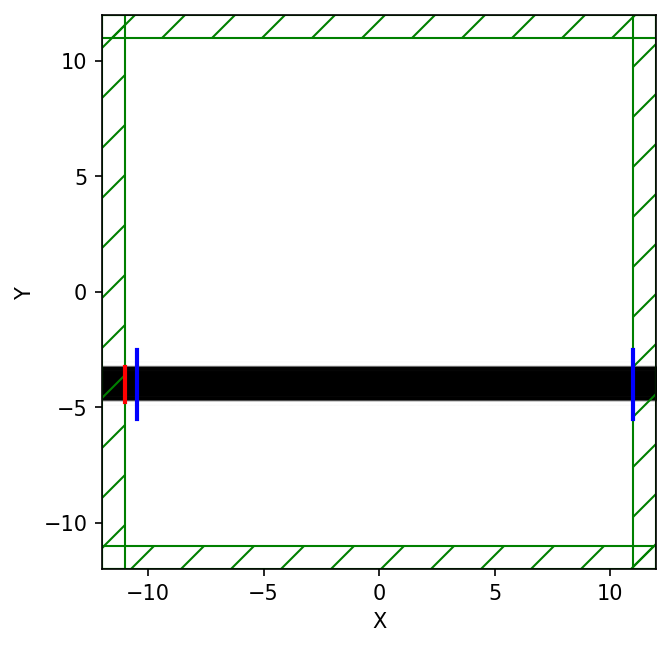

-----------
Initializing structure...
time for choose_chunkdivision = 0.000167131 s
Working in 2D dimensions.
Computational cell is 24 x 24 x 0 with resolution 10
     block, center = (0,-4,0)
          size (24,1.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)
time for set_epsilon = 0.067605 s
-----------
field decay(t = 50.050000000000004): 1.4374164736782128e-10 / 1.4374164736782128e-10 = 1.0
field decay(t = 100.05000000000001): 1.5492514085225114e-05 / 1.5492514085225114e-05 = 1.0
field decay(t = 150.1): 0.03208908045286002 / 0.03208908045286002 = 1.0
field decay(t = 200.15): 8.539592240716198e-05 / 0.03208908045286002 = 0.00266121438202667
field decay(t = 250.20000000000002): 1.8648780858223826e-14 / 0.03208908045286002 = 5.811565989128152e-13
run 0 finished at t = 250.20000000000002 (5004 timesteps)


In [6]:
## simulation of straight wg
sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)
sim.reset_meep()
nfreq = 200  # number of frequencies at which to compute flux

# reflected flux
refl_fr = mp.FluxRegion(
    center=mp.Vector3(-0.5 * sx + dpml + 0.5, y_loc, 0), size=mp.Vector3(0, 2 * w, 0)
)
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

# transmitted flux
tran_fr = mp.FluxRegion(
    center=mp.Vector3(0.5 * sx - dpml, y_loc, 0), size=mp.Vector3(0, 2 * w, 0)
)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

plt.figure(dpi=150)
sim.plot2D( field_parameters={'alpha':0.8, 'cmap':'RdBu'})
plt.show()

pt = mp.Vector3(0.5 * sx - dpml - 0.5, y_loc)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, pt, 1e-5))

# for normalization run, save flux fields data for reflection plane
straight_refl_data = sim.get_flux_data(refl)
# save incident power for transmission plane
straight_tran_flux = mp.get_fluxes(tran)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000419855 s
Working in 2D dimensions.
Computational cell is 24 x 24 x 0 with resolution 10
     block, center = (-6,-4,0)
          size (12,1.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)
     block, center = (0.75,3.625,0)
          size (1.5,16.75,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)
     cylinder, center = (3.2,-5.7,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)
     cylinder, center = (3.2,-5.7,0)
          radius 1.3, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.113912 s
-----------
field decay(t = 50.050000000000004): 2.6174688429716703e-08 / 2.6174688429716703e-08 = 1.0
field decay(t = 100.05000000000001): 2.3980599756412363e

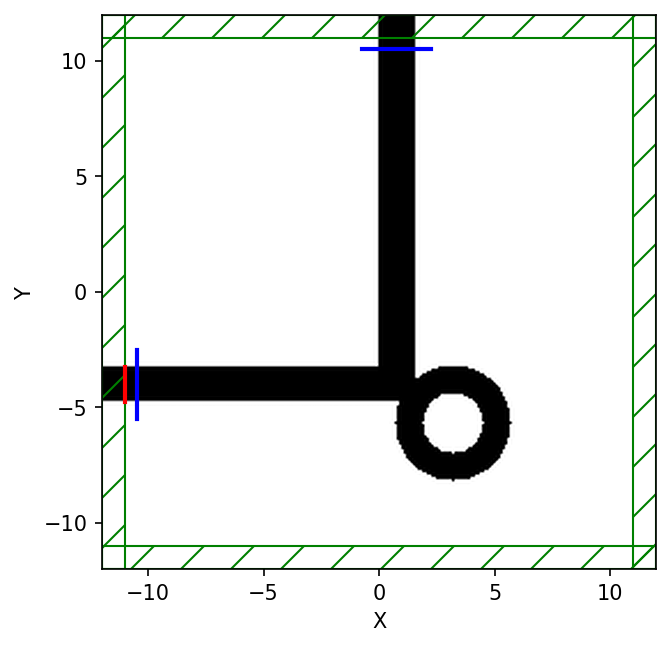

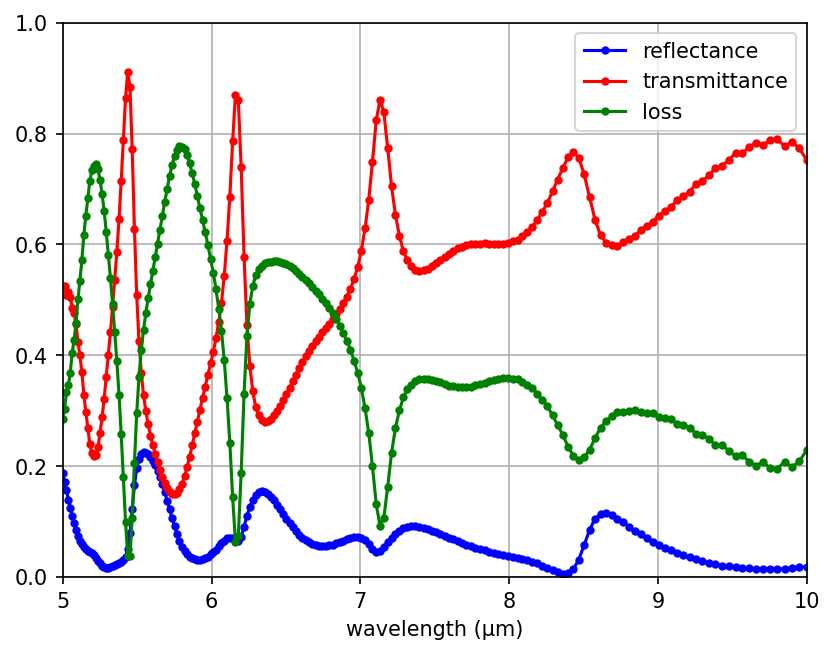

In [7]:

geometry = [
    mp.Block(
        mp.Vector3(sx/2 , w),
        center = mp.Vector3(-sx/4, y_loc),
        material = Si,
    ),
    mp.Block(
        mp.Vector3(w, sy/2 - y_loc + w /2),
        center=mp.Vector3( w/2, sy/4 + y_loc/2 - w/4),
        material = Si,
    ),
    mp.Cylinder(
        radius = 2.5,
        center=mp.Vector3(  w + 1.7, y_loc - 1.7 ),
        material = Si,
    ),
    mp.Cylinder(
        radius = 1.3,
        center=mp.Vector3(  w + 1.7, y_loc - 1.7 ),
        material=mp.Medium(epsilon=1),
    ),

]

sim_ring_bend = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)
sim_ring_bend.reset_meep()
# reflected flux
refl = sim_ring_bend.add_flux(fcen, df, nfreq, refl_fr)

tran_fr = mp.FluxRegion(
    center = mp.Vector3( w/2, 0.5 * sy - dpml - 0.5), size=mp.Vector3(2 * w, 0, 0)
)
tran = sim_ring_bend.add_flux(fcen, df, nfreq, tran_fr)

# for normal run, load negated fields to subtract incident from refl. fields
sim_ring_bend.load_minus_flux_data(refl, straight_refl_data)

pt = mp.Vector3( w/2, 0.5 * sy - dpml - 0.5)

sim_ring_bend.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, pt, 1e-5))

bend_refl_flux = mp.get_fluxes(refl)
bend_tran_flux = mp.get_fluxes(tran)

flux_freqs = mp.get_flux_freqs(refl)

plt.figure(dpi=150)
sim_ring_bend.plot2D()
plt.show()

wl = []
Rs = []
Ts = []

for i in range(nfreq):
    wl = np.append(wl, 1 / flux_freqs[i])
    Rs = np.append(Rs, -bend_refl_flux[i] / straight_tran_flux[i])
    Ts = np.append(Ts, bend_tran_flux[i] / straight_tran_flux[i])

As = 1 - Rs - Ts
    
if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Rs, "b.-", label="reflectance")
    plt.plot(wl, Ts, "r.-", label="transmittance")
    plt.plot(wl, As, "g.-", label="loss")
    plt.axis([5.0, 10.0, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.legend(loc="upper right")
    plt.grid()
    plt.show()

In [8]:
print(np.argmax(Ts))
print(max(Ts))
print(wl[np.argmax(Ts)])

167
0.9117379088267888
5.437158469945355


In [9]:
import mycmapls as ms# colormap defined in mycmapls.py

sources = [
    mp.Source(
        mp.ContinuousSource(frequency=1/wl[np.argmax(Ts)]),
        component=mp.Ez,
        center=mp.Vector3(-0.5 * sx + dpml, y_loc, 0),
        size=mp.Vector3(0, w, 0),
    )
]

sim_ring_bend_cw = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)

## rerun simulation, recored plot a every 0.5, and generate movie 
sim_ring_bend_cw.reset_meep()

f = plt.figure(dpi=100)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False,
                       normalize=True, field_parameters={'alpha':0.8,'cmap':ms.bifan})
plt.close()
sim_ring_bend_cw.run(mp.at_every(0.5, Animate), until=300)
plt.close()
filename = "ring_bend_waveguide.mp4"
Animate.to_mp4(10, filename)

-----------
Initializing structure...
time for choose_chunkdivision = 0.0001719 s
Working in 2D dimensions.
Computational cell is 24 x 24 x 0 with resolution 10
     block, center = (-6,-4,0)
          size (12,1.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)
     block, center = (0.75,3.625,0)
          size (1.5,16.75,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)
     cylinder, center = (3.2,-5.7,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)
     cylinder, center = (3.2,-5.7,0)
          radius 1.3, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.123879 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

     block, center = (-6,-4,0)
          size (12,1.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)
     block, center = (0.75,3.625,0)
          size (1.5,16.75,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)
     cylinder, center = (3.2,-5.7,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)
     cylinder, center = (3.2,-5.7,0)
          radius 1.3, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
Meep progress: 244.0/300.0 = 81.3% done in 4.0s, 0.9s to go
on time step 4880 (time=244), 0.000819811 s/step
Normalizing field data...
run 0 finished at t = 300.0 (6000 timesteps)
Generating MP4...


     block, center = (0,0,0)
          size (24,24,0)
          axes (1,0,0), (0,1,0), (0,0,1)


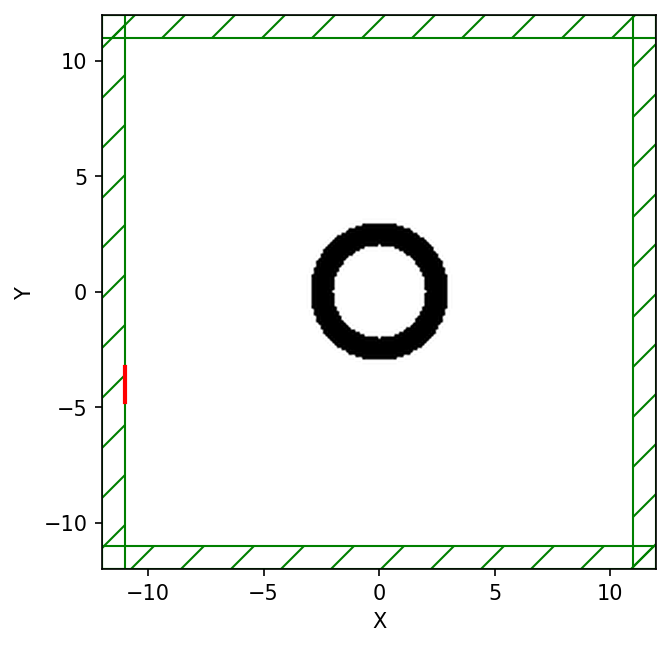

In [11]:
## define arbitraty shape
def ring_resonator(p):
    rr = (p.x**2+p.y**2)**0.5
    if (rr > 2) and (rr < 3):
        return mp.Medium(index=2)
    return mp.air

ring_resonator.do_averaging = True

geometry = [mp.Block(center=mp.Vector3(),
                     size=mp.Vector3(sx,sy),
                     material=ring_resonator)]

sim = mp.Simulation(cell_size=mp.Vector3(sx,sy),
                    geometry=geometry,
                    subpixel_tol=1e-4,
                    subpixel_maxeval=1000,
                    sources=sources,
                    resolution=resolution,
                    boundary_layers=[mp.PML(dpml)])
plt.figure(dpi=150)
sim.plot2D()
plt.show()